# Entry Guidance

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
seaborn.set_style("whitegrid")

from EntryGuidance import Mesh 
from EntryGuidance import EntryEquations as EE
from EntryGuidance import Convex_Entry as CVX
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute 

In [ ]:
traj,bank_profile = MC.solve_ocp(dr=850)

In [15]:
reload(Mesh)
reload(EE)
reload(CVX)
reload(MC)

<module 'EntryGuidance.MonteCarloV' from 'E:\\Documents\\EDL\\EntryGuidance\\MonteCarloV.py'>

In [16]:
mc = MC.MonteCarlo()
X,U_cvx,x_ref,u_ref,x_int = mc.reference_data(bank_profile, np.array(traj['state'])[-1,3])

r,th,ph,v,fpa,psi,bank = x_ref
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Original final altitude: {:.2f} km".format(h[-1]))
print("Original final velocity: {:.2f}".format(v[-1]))

r,th,ph,v,fpa,psi,bank = X
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Replanned final altitude: {:.2f} km".format(h[-1]))
print("Replanned final velocity: {:.2f}".format(v[-1]))
U = {}
U['CVX'] = U_cvx
U['Reference'] = u_ref

Generating reference data...
...done. 
(1447, 8)
Generating linearization about reference data...
...done.
Solving convex optimization problem...
status:        optimal_inaccurate
optimal value: 0.243
solution time:  1.685 s
setup time:     1.555 s
penalty value:  1.8692134768446257e-07

...done.

Original final altitude: 11.00 km
Original final velocity: 469.97
Replanned final altitude: 10.96 km
Replanned final velocity: 470.29


In [ ]:
plt.close('all')
fs = (16,8)
fontsize = 14
for xi,spec,label in zip([x_ref,X,x_int],['k--','r','b'],['Reference','CVX','Integrated']):
    if not "CVX" in label or True:
        r,th,ph,v,fpa,psi,bank = xi
        
        plt.figure(1, figsize=fs)
        plt.plot(v,r/1000-3397, spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Altitude (km)', fontsize=fontsize)
        plt.legend(loc='best')

        plt.figure(10, figsize=fs)
        plt.plot(v[v<600],r[v<600]/1000-3397, spec, label=label)
        Parachute.Draw(10)
        plt.legend(loc='best')

        
        plt.figure(2, figsize=fs)
#         plt.plot(np.degrees(th),np.degrees(ph),spec,label=label)
#         plt.ylabel('Latitude (deg)', fontsize=fontsize)
#         plt.xlabel('Longitude (deg)', fontsize=fontsize)
        cr = (-3397*ph)
        plt.plot(th*3397,cr,spec,label=label)

#         plt.plot(th[cr>0.01]*3397,cr[cr>0.01],spec,label=label)
#         plt.plot(790, 0, 'ko', markersize=10, label='Target')

        plt.xlabel('Downrange (km)', fontsize=fontsize)
        plt.ylabel('Crossrange (km)', fontsize=fontsize)
        plt.legend(loc='best')
        
        plt.figure(3, figsize=fs)
        plt.plot(v,np.degrees(bank),spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Bank (deg)', fontsize=fontsize)
        plt.legend(loc='best')



#         plt.figure(5, figsize=fs)
#         # plt.plot(v,np.degrees(th),spec)
#         plt.plot(v,-3397*ph,spec, label=label)
#         plt.ylabel('Crossrange (km)')
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
        plt.figure(6, figsize=fs)
        plt.plot(v,np.degrees(psi),spec)
        plt.ylabel('Heading (deg)', fontsize=fontsize)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
#         plt.figure(4, figsize=fs)
#         plt.plot(v,np.degrees(U[label]),spec)
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
#         plt.ylabel('Bank rate (deg/s)', fontsize=fontsize)




plt.show()

# Landing Guidance - SRP
## Differential Flatness (BSpline) + SQP approach

In [ ]:
from EntryGuidance import bsplinePDG as PDG
reload(PDG)
PDG.optimize()

## GPOPS Solution to SRP 

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')
from scipy.io import savemat, loadmat
import os

from Utils.gpops import srp as srp_opt
from EntryGuidance.TrajPlot import TrajPlot

In [ ]:
x0 = [-3200., 0., 3200., 625., 60., -270., 8500.]
traj = srp_opt((x0,))
# print((traj['time'][-1]))
u = np.array(traj['control']).T
# plt.figure(1, figsize=(14,8))
# TrajPlot(*(np.array(traj['state'])[:,0:3].T), T=(u[0]*u[1:4]).T/1000 , show=True, figNum=1)

In [2]:
import chaospy as cp
x0 = [-3200., 0., 3200., 625., 0., -270., 8500.]
ux = cp.Uniform(x0[0]-1200,x0[0]+400)
uy = cp.Uniform(x0[1]-2000,x0[1]+2000)
uz = cp.Uniform(x0[2]-600,x0[2]+800)
uu = cp.Uniform(x0[3]-40,x0[3]+100)
uv = cp.Uniform(x0[4]-100,x0[4]+100)
uw = cp.Uniform(x0[5]-40,x0[5]+40)
D = cp.J(ux,uy,uz,uu,uv,uw)

R = D.sample(999, 'S').T
# R = uz.sample(100,'S')
print(R.shape)

(1000, 6)


From each trajectory, save the solution vector (7 initial costates + 1 final time) as well as the entire array of states and controls

In [ ]:
x0 = [-3200., 0., 3300., 625., 0., -270., 8500.]
savedir = "./data/mae278/test"
it0 = len([1 for file in os.listdir(savedir) if file.endswith('.mat')])
for it,r in enumerate(R, start=it0):
#     print("Solving from initial state {} m".format(r))
#     print("Iter {}".format(it))

    r = [float(ri) for ri in r]
    x0[0:6] = r
#     x0[2] = float(r)
    traj = srp_opt((x0,))
    
    
    t = np.array(traj['time']).squeeze()
    l = np.array(traj['costate'])
    sol = l[0].tolist() + [t[-1]]
    traj['time'] = t
    traj['costate'] = l
    traj['state'] = np.array(traj['state'])
    traj['control'] = np.array(traj['control'])
    traj['sol'] = sol
    traj.pop('timeRadau', None)
    traj.pop('controlRadau', None)
    traj.pop('pathmultipliers', None)

    savemat(savedir+"/srp_{}.mat".format(it), traj)

In [ ]:
loaddir = "./data/mae278/alt_sweep_fixed/"
plt.figure(100, figsize=(12,12))
z0 = []
sol = []
tf = []
for file in os.listdir(loaddir):
#     print(file)
    if not file.endswith('.mat'):
        continue
    data = loadmat(loaddir+file, squeeze_me=True)
    x = data['state'].T
#     tf.append(np.array(data['time']).squeeze()[-1])
    print(np.max(x[0]))
    if np.all(x[0]<=0):
        TrajPlot(*x[0:3], figNum=100)
    z0.append(x[2,0])
    sol.append(data['sol'])
I = np.argsort(z0)
# plt.figure(16,figsize=(12,12))
# plt.plot(np.array(z0)[I],np.array(sol)[I,:])
# plt.xlabel('Initial Altitude (m)')
# plt.ylabel('Costates')
# plt.legend(['x','y','z','u','v','z'])

In [25]:
print(np.mean(tf))
print(np.max(tf))
print(np.min(tf))

15.228431129802608
19.132580241869892
11.8704813225191


## Convex Optimization

In [124]:
import EntryGuidance.Convex_PS as Convex
from importlib import reload
reload(Convex)
OCP = Convex.OCP
import cvxpy as cvx
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')


In [220]:
class SRP(OCP):
    def __init__(self, x0, xf, ubounds, xf_idx=None, scale=1):
        # xf is a REDUCED list of final states, len(xf)=len(xf_idx)
        # xf_idx is a list of indices for fixed final states such that x[xf_idx] = xf
        self.vei = 0.00034 # escape velocity inverse= 1/(Isp*g0), system is linear with no mass loss when = 0        
        
        self.x0 = np.array(x0)
        
        if xf_idx is not None:
            assert len(xf)==len(xf_idx)
            self.xfi = xf_idx
        else:
            self.xfi = list(range(self.x0.size))
            
        self.scale = scale  
        self.ubounds = np.asarray(ubounds) / self.scale
        self.x0 = np.array(x0) / self.scale
        self.xf = np.array(xf)
        
    def dynamics(self, x, t, U):
        u = U(t).T * self.scale
        p = x[0:3] * self.scale
        v = x[3:6] * self.scale
        m = x[6]   * self.scale
        
        g = np.array([0, 0, 3.71])
        if x.ndim>1:
            g = g[:,None]
        dx = np.empty(x.shape, dtype=x.dtype)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -self.vei * (u[0]**2 + u[1]**2 + u[2]**2)**0.5   
        return dx/self.scale
        
    def jac(self, x, u):
        u = u.copy() * self.scale
        m = x[6]*self.scale
        
        A = np.zeros((x.shape[1],7,7))
        A[:, 0:3][:, :, 3:6] = np.eye(3)
        A[:, 3:6][:, :, 6] = (-u/m**2).T

        B = np.zeros((x.shape[1],7,3))
        B[:, 3, 0] = 1/m
        B[:, 4, 1] = 1/m
        B[:, 5, 2] = 1/m 
        B[:, 6] = (-self.vei * u/(u[0]**2 + u[1]**2 + u[2]**2)**0.5).T
        return A,B 
    
    def check_jac(self, x, u):
        from Utils.DA import compute_jacobian
        
        xu = np.concatenate((x,u), axis=0)        
        return compute_jacobian(lambda xu: self.dynamics(xu[:7], 0, lambda t: xu[7:]), xu)
    
    def constraints(self, t, x, u, x_ref, u_ref):
        bc = [x[-1][self.xfi] == self.xf, x[0] == x_ref[0]]
        
        umin, umax = self.ubounds
        dT_max = 1*umax # Newtons
        dm = 500/self.scale # kg 
        constr = []
        for ti, xr in zip(t, x_ref):
            du = u[ti]-u_ref[ti]
#             if ti:
#                 dudt = (u[ti] - u[ti-1])
#                 constr += [cvx.norm(dudt) < 0.2 * umax]
            constr += [cvx.norm(u[ti])/umax <= 1] # Convex upper bound on total thrust
#             constr += [cvx.norm(u[ti])/umin >= 1] # Non-convex lower bound on total thrust
#             constr += [cvx.norm(du) <= dT_max]   # Convex upper bound on change in thrust

#             constr += [u[ti][1] > 0]
            if ti:
                constr += [x[ti][-1] <= x[ti-1][-1]] # non-increasing mass 
#             constr += [cvx.norm(x[ti][-1]-xr[-1]) < dm] # Bound on change in mass 
        return constr + bc
        
    def mayer(self, xf):
        return 0 
#         return cvx.Problem(cvx.Minimize(-xf[-1]))
    
    def lagrange(self, t, x, u):
        return np.array([cvx.norm(ui) for ui in u])/self.ubounds[1]
#         return np.zeros((len(x),))
        
    def plot(self, T, U, X, J, meshpts):
        xopt = X[-1] * self.scale 
        uopt = U[-1] * self.scale 
        label = "Convex"
        print("Fuel consumed = {} kg".format(xopt[-1,0]-xopt[-1,-1]))
        
        plt.figure(1)
        plt.plot(T[-1], xopt[-1], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        
        plt.figure(2)
        plt.plot(T[-1], xopt[0:3].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        
        plt.figure(3)
        plt.plot(T[-1], xopt[3:6].T, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        
        plt.figure(4)
        plt.plot(T[-1], np.linalg.norm(uopt, axis=1), label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        
        plt.figure(5)
        plt.plot(T[-1], uopt/np.linalg.norm(uopt, axis=1)[:,None], label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        
#         self.mesh.plot()
        
    def guess(self):
        

        guess = {}
        if False:
            data = loadmat("./data/mae278/srp_10.mat", squeeze_me=True)
            guess['time'] = data['time']
            guess['state'] = data['state']/self.scale 
            guess['mesh'] = [4]*3
            guess['control'] = data['control'][:,0:1]*data['control'][:,1:4]/self.scale 
            
        else: # Simple linear guess 
            guess['time'] = np.linspace(0,16)
            guess['mesh'] = [6]*1

            x_guess = np.array([np.linspace(x,1) for x in self.x0]).T
            x_guess[:,6] = np.linspace(self.x0[-1], 0.72*self.x0[-1])
            guess['state'] = x_guess
            guess['control'] = -x_guess[0,3:6]/16. * x_guess[:,6:]
        return guess 
    
    def gpops(self):
        from Utils.gpops import srp as srp_opt
        traj = srp_opt(([float(x0*self.scale) for x0 in self.x0],))

        u = np.array(traj['control']).T
        t = traj['time']
        x = np.array(traj['state']).T
        label = "GPOPS"
        plt.figure(1)
        plt.plot(t, x[-1], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Mass (kg)')
        plt.legend()
        plt.figure(2)
        plt.plot(t, x[0:3].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.legend()
        plt.figure(3)
        plt.plot(t, x[3:6].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.legend()
        
        plt.figure(4)
        plt.plot(t, u[0], '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.legend()
        
        plt.figure(5)
        plt.plot(t, u[1:4].T, '--', label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Control Directions')
        plt.legend()

In [221]:
m0 = 8500
x0 = np.array([-3200., 400, 3200, 625., -80, -270., m0])
xf = np.zeros((6,))
xfi = np.arange(6)
ubnds = np.array([40,70])*m0 # Newtons 
srp = SRP(x0=x0, xf=xf, xf_idx=xfi, ubounds=ubnds, scale=m0)
print(srp.ubounds)

[40. 70.]


Iteration 0
status:        optimal
optimal value: 10.084
solution time:  0.025 s
setup time:     0.01 s
penalty value:  5.0673366226448805e-11

Mesh refinement resulted in 2 segments with 7 collocation points

Iteration 1
status:        optimal
optimal value: 9.983
solution time:  0.05 s
setup time:     0.02 s
penalty value:  8.64231781087497e-08

Relative change in cost function = 1.02%
Mesh refinement resulted in 3 segments with 13 collocation points

Iteration 2
status:        optimal
optimal value: 9.943
solution time:  0.088 s
setup time:     0.032 s
penalty value:  1.7862823954245923e-08

Relative change in cost function = 0.40%
Mesh refinement resulted in 6 segments with 21 collocation points

Iteration 3
status:        optimal
optimal value: 9.927
solution time:  0.209 s
setup time:     0.068 s
penalty value:  4.102981969256273e-08

Relative change in cost function = 0.15%
Mesh refinement resulted in 9 segments with 37 collocation points

Iteration 4
status:        optimal
opti

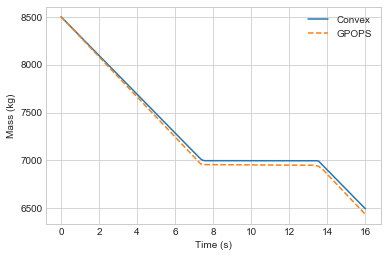

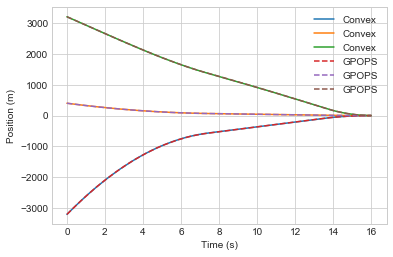

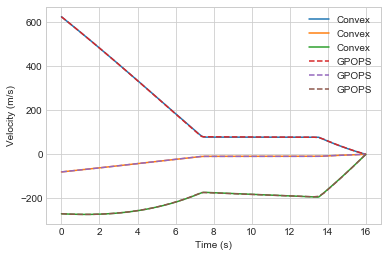

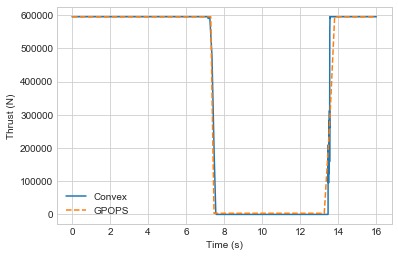

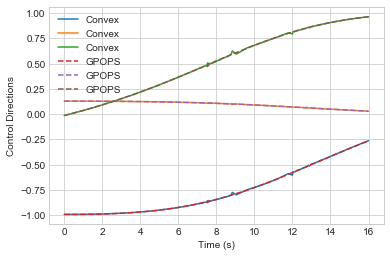

In [222]:
srp.solve(srp.guess(), max_size=300, max_iter=20) #scaling=np.array([10,5,10,1,1,1,15])*5
srp.gpops()


Verify that jacobian is implemented correctly 

In [148]:
x0 = srp.x0
u0 = np.array([70.,70,70])/srp.scale
u = np.array([60.,75,65])/srp.scale
x = np.array([-3100., 350, 3000, 615., -70, -260., m0*0.98])/srp.scale
# print(x)
# print(x0)
f0 = srp.dynamics(x0, 0, lambda t: u0)
f = srp.dynamics(x, 0, lambda t: u)
print(f)
print(f0)
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
flinear = f0 + (A[0].dot(x-x0) + B[0].dot(u-u0))
print(flinear)
print(np.linalg.norm(f-flinear, np.inf))

[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.47397783e-07
  1.05924723e-06 -4.35552574e-04 -4.63896540e-06]
[ 7.35294118e-02 -9.41176471e-03 -3.17647059e-02  9.68858131e-07
  9.68858131e-07 -4.35501730e-04 -4.84974226e-06]
[ 7.23529412e-02 -8.23529412e-03 -3.05882353e-02  8.49826990e-07
  1.05743945e-06 -4.35551557e-04 -4.61880215e-06]
2.0163248380274508e-08


In [149]:
A,B = srp.jac(np.array([x0,x]).T, np.array([u0,u]).T)
J = srp.check_jac(x, u)

print(J.shape)
print(A.shape)
print(B.shape)
Jana = np.concatenate((A[1],B[1]), axis=1)
err = np.abs(Jana-J)
print(np.linalg.norm(err, np.inf))
# print(err)

(7, 10)
(2, 7, 7)
(2, 7, 3)
1.3552527156068805e-19


## Indirect Approach

In [7]:
# These are closed loop dynamics that depend on the initial costate 
def dynamics(x, t, l0):
    # Problem constants
    Isp = 290;
    g0 = 9.81;
    ve = Isp*g0;
    Tmax = 70*8500
    Tmin = 40*8500
    
    # States being integrated
    r = x[0:3]
    v = x[3:6]
    m = x[6]
    lm = x[7] # Mass costate 
    
    # Costates
    lr = l0[0:3]
    lv0 = l0[3:6]
    lv = lv0 - lr*t
    u = -lv/np.linalg.norm(lv) # Optimal thrust direction
    
    # Optimal thrust magnitude
    S = -lm/ve + np.dot(lv, u)/m
    if S < 0:
        T = Tmax
    else:
        T = Tmin
    
    # State derivatives
    g = np.array([0,0,3.71])
    dx = np.empty(x.shape)     
    dx[0:3] = v
    dx[3:6] = T*u/m - g
    dx[6] = -T/ve    
    dx[7] = T*np.dot(lv, u)/m**2
    return dx

In [7]:
# l0 = np.array([0.204346904081385,	0.0663646852284269,	0.201041129500207,	3.17235427027352,	0.470730385571971,	0.565067899039915,	-0.748860889946803])
# x0 = np.array([-3200., 400, 3200, 625., 0, -270., m0, l0[-1]])
# tf = 14.0035
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
tf=16
print("True prop usage = {} kg".format(data['state'][0,6]-data['state'][-1,6]))

True prop usage = 2412.5166200060476 kg


In [10]:
data = loadmat("./data/mae278/srp_566.mat", squeeze_me=True)
x0 = data['state'][0]
l0 = data['costate'][0]
x0 = np.append(x0, l0[-1])
t = np.linspace(0,tf)
X = odeint(dynamics, x0, t, args=(l0,))
print("Miss distance: {:.1f} m".format(np.linalg.norm(X[-1,:3])))
print("Velocity error: {:.1f} m".format(np.linalg.norm(X[-1,3:6])))
print("Prop used: {:.2f}".format(X[0,6]-X[-1,6]))

Miss distance: 54.4 m
Prop used: 2426.57


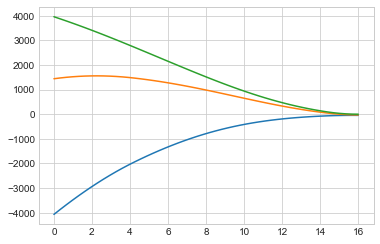

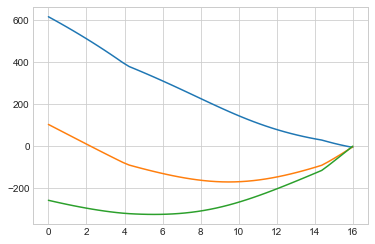

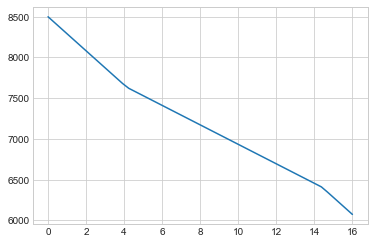

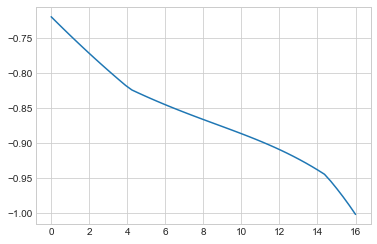

In [9]:
plt.figure()
plt.subplot(131)
plt.plot(t, X[:,0:3])
plt.subplot(132)
plt.plot(t, X[:,3:6])
plt.subplot(133)
plt.plot(t, X[:,6])
# plt.figure()
# plt.plot(t, X[:,7])

In [7]:
from EntryGuidance import Riccati
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 


In [8]:
A = lambda x: np.array([x]).squeeze()
B = lambda x,u: np.array([1+x**2])
C = lambda x: np.array([1]) # Output equation linearization 
Q = lambda x: np.array([1-0.1*x**2]).squeeze() # State weight - less weight when far away 
R = lambda t: np.array([0.5/(1+t)]) # Control weight
z = lambda t: np.array([1+np.sin(t)+0.2*np.cos(2*t)/2]) #np.array([0]) # Reference trajectory
F = lambda x: Q(x)/10 #np.array([0]) # Final State weight 

tf = 12

x0 = np.array([1])
x, u, K = Riccati.ASRE(x0, tf, A, B, C, Q, R, F, z, tol=1e-3, max_iter=50, n_discretize=5000)
t = np.linspace(0, tf, x.size)

Uc = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) - interp1d(t, K.squeeze(), axis=0, bounds_error=False, fill_value=0)(T)*(X - interp1d(t, x, axis=0, bounds_error=False, fill_value=0)(T))
Uo = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) 

d = lambda x,t: 0.1*np.sin(t)*x
f = lambda x,t,u: x**2 + (1+x**2)*u(t,x) + d(x,t)

x_ol = odeint(f, x0, t, args=(Uo,)) # This should match with zero error essentially 
x_cl = odeint(f, np.linspace(0,2,10), t, args=(Uc,))
u_cl = [Uc(ti,xi) for ti,xi in zip(t,x_cl.squeeze())]
ref = z(t).squeeze()

Approximating Sequence of Riccati Equations
Max iterations: 50
Current iteration: 1
Current cost: 0.7895710251969738
Current iteration: 2
Current cost: 0.6088560399458006
Current iteration: 3
Current cost: 0.5991445034266731
Current iteration: 4
Current cost: 0.5963617844606172
Current iteration: 5
Current cost: 0.5960904171646377
Convergence achieved. 


E:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


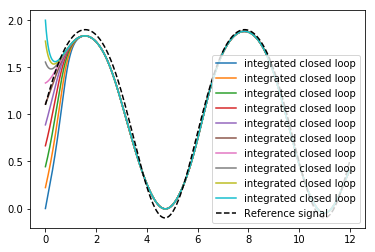

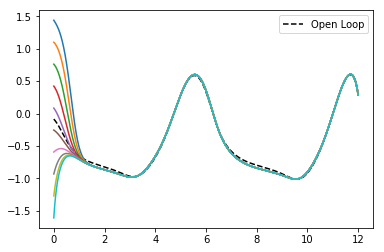

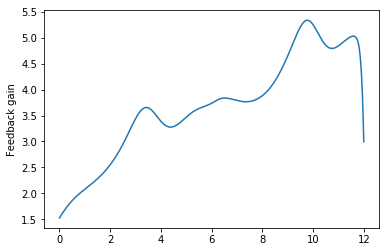

In [9]:
# plt.plot(t, x, 'mo',label='approx')
# plt.plot(t, x_ol, 'k-^', label='integrated open loop')
plt.plot(t, x_cl, label='integrated closed loop')
plt.plot(t, ref, 'k--', label='Reference signal')

plt.legend()

plt.figure()
plt.plot(t, u, 'k--', label='Open Loop')
plt.plot(t, u_cl)
plt.legend()

plt.figure()
plt.plot(t, K.squeeze())
plt.ylabel('Feedback gain')
plt.show()

## Closed loop covariance propagation
How does saturation effect the evolution?

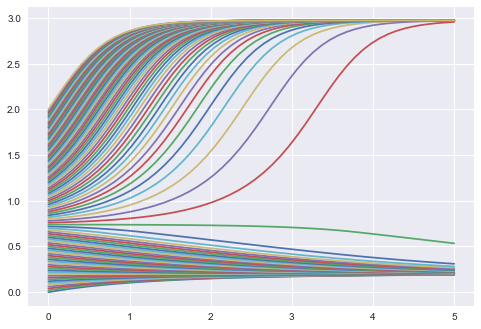

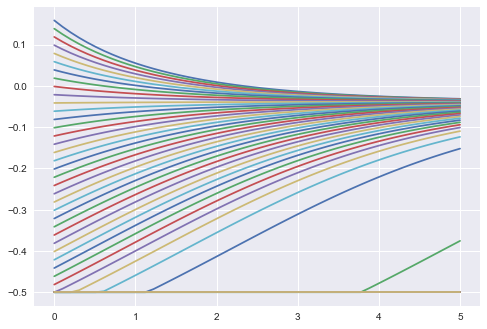

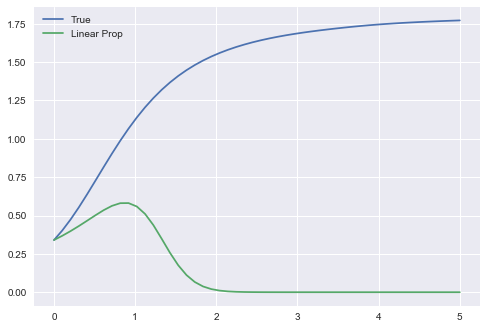

In [5]:
from EntryGuidance.Unscented import Transform 
tf = 5

x0 = np.linspace(0.,2,101)
t = np.linspace(0, tf, 50)

umax = 0.5
k = 1.
U = lambda t,x: np.clip(-np.sin(1)-k*(x-1), -umax, umax)
f = lambda x,t: np.sin(x)*x + U(t,x)
fp= lambda p,t,x: 2*p*(np.sin(x(t)) + x(t)*np.cos(x(t)) - k)

x = odeint(f, x0, t)
x_mean = odeint(f, np.mean(x0), t)
# x_mean = np.mean(x, axis=1)

u = [U(ti, xi) for ti,xi in zip(t,x.squeeze())]
P =  np.var(x, axis=1)
xt = interp1d(t,x_mean, axis=0, bounds_error=False, fill_value=(x_mean[0],x_mean[-1]))
Plin = odeint(fp, P[0], t, args=(xt,))

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,u)

plt.figure()
plt.plot(t,P, label='True')
plt.plot(t,Plin, label='Linear Prop')
plt.legend()
plt.show()

In [1]:
import cvxpy as cvx

In [4]:
n = 3
x = cvx.Variable(n)
H = np.diag([1,-1,1.])
c = np.random.random((n,))

# print cvx.quad_form(x,H)
# print x[0]
constraint = [cvx.quad_form(x,np.abs(H)) < 1]
# constraint = [(x[0]**2 - x[1]**2 + x[2]**2)**2 < 1]

problem = cvx.Problem(cvx.Minimize(c*x), constraint)
problem.solve()
print x.value
print x.value.A.T.dot(np.abs(H)).dot(x.value.A)

[[-0.59096725]
 [-0.39423826]
 [-0.70379961]]
[[1.]]


In [7]:
print (cvx.quad_form(x,(H)) < 1).is_dcp()

False


e:\anaconda\lib\site-packages\cvxpy\atoms\quad_form.py:82: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
